# Sync Code

Clone the GitHub Repo


In [ ]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

fatal: destination path 'training_camp_21_22' already exists and is not an empty directory.


`Move to the Python Project root folder` and install requirements

In [ ]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-clustering

In [ ]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN
To: /root/.kaggle/kaggle.json
100% 74.0/74.0 [00:00<00:00, 116kB/s]


Download the input file (training and test)

In [ ]:
!mkdir -p data/task_1

In [ ]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

pitc-2122-clustering.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pitc-2122-clustering.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder 

In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


Set the Python Path variable to the source folder

In [ ]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow_decision_forests as tfdf

import training_camp_21_22.config
import training_camp_21_22.data.commercial_offer
import training_camp_21_22.models
import training_camp_21_22.view.classification

# Preprocess Data

Dowload the data

In [ ]:
import json
json_input_path='/content/training_camp_21_22/data/task_1/train.csv'

def convert_json_2_pd(json_input_path):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    df_train=pd.read_csv(json_input_path)

    features_df = pd.DataFrame(columns=['user','age','location', 'fasciaF1ConsumoFatturato','fasciaF2ConsumoFatturato','fasciaF3ConsumoFatturato'])

    for i in range(len(df_train)):
      event = df_train["events"][i]
      lst = [] 
      row_data = json.loads(event)
      lst.append(df_train["user"][i])

      # bamData.items.bamItem.addresses: List of Address
      lst.append(row_data[0]["bamData"]["items"]["bamItem"]["personInfo"]["birthDate"])
      lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['zipCode']['code'])
      
      

      # bamData.items.customData: energy consumption information
      # lst.append (row_data[0]["customData"]['billing_range']['from_date'])
      # lst.append (row_data[0]["customData"]['billing_range']['to_date'])

      # bamData.items.customData.energy: Energy Consumption related for the period in scope
      lst.append(row_data[0]["customData"]["energy"]["fasciaF1ConsumoFatturato"])
      lst.append(row_data[0]["customData"]["energy"]["fasciaF2ConsumoFatturato"])
      lst.append(row_data[0]["customData"]["energy"]["fasciaF3ConsumoFatturato"])
      features_df.loc[i]=lst

    labels_df = df_train[['user','cluster']]

    return features_df , labels_df

features_df , labels_df = convert_json_2_pd(json_input_path)

In [ ]:
features_df.head(10)

,user,age,location,f1,f2,f3
0,6,1927-05-03,30020,44.0,73.0,0.0
1,13,1953-05-21,98051,55.0,62.0,26.0
2,14,1984-11-11,80121,44.0,17.0,46.0
3,17,1998-06-02,20121,3.0,10.0,22.0
4,34,2003-02-01,80121,0.0,0.0,35.0
5,35,1970-05-05,00118,2.0,22.0,20.0
6,47,1986-01-02,17100,26.0,14.0,43.0
7,52,1983-07-07,20098,18.0,55.0,50.0
8,63,1995-02-03,23900,6.0,35.0,43.0
9,73,1935-04-07,52043,48.0,78.0,15.0


In [ ]:
features_df.columns=['user','age','location','f1','f2','f3']


In [ ]:
features_df['age'] =pd.to_datetime(features_df['age'])
import datetime as dt
now_year =dt.datetime.today().year 
features_df['age']=now_year-features_df.age.dt.year
features_df

,user,age,location,f1,f2,f3
0,6,95,30020,44.0,73.0,0.0
1,13,69,98051,55.0,62.0,26.0
2,14,38,80121,44.0,17.0,46.0
3,17,24,20121,3.0,10.0,22.0
4,34,19,80121,0.0,0.0,35.0
...,...,...,...,...,...,...
69995,69939,39,10121,37.0,18.0,46.0
69996,69969,72,20831,13.0,37.0,22.0
69997,69977,25,28100,23.0,16.0,36.0
69998,69985,75,73014,20.0,23.0,28.0


Let's have a look at the collected data!

In [ ]:
labels_df.head()

,user,cluster
0,6,1
1,13,0
2,14,1
3,17,2
4,34,2


Load the commercial offers

In [ ]:
#Label 0
mono_oraria = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.28, "f2": 0.28, "f3": 0.28}, name="mono_oraria")

# Label 1
serale = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.31, "f2": 0.26, "f3": 0.26}, name="serale")

# Lael 2
notturna = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.56, "f2": 0.56, "f3": 0.}, name="notturna")

commercial_offers = [mono_oraria, serale, notturna]
class_names = [co.name for co in commercial_offers]

#Baseline Classifier

The label is computed by "extending" the mean consumptions over the whole year

In [ ]:
def project_over_year(df, commercial_offers):
    
    def best_projected_offer(row):
        columns = [co.name for co in commercial_offers]
        cluster = np.argmin(row[columns])
        return cluster
        
    year_projection = 12 * df.groupby(by=["user"]).mean()

    for offer in commercial_offers:
        year_projection[offer.name] = year_projection.apply(
            offer.compute_yearly_cost, axis=1)

    year_projection["cluster"] = year_projection.apply(
        best_projected_offer, axis=1)
    year_projection = year_projection.drop(
        [co.name for co in commercial_offers], axis=1)

    return year_projection


year_projection_df = project_over_year(
    features_df, commercial_offers)

Let's have a look at the projection!

In [ ]:
year_projection_df.head()

,f1,f2,f3,cluster
user,,,,
0,504.0,456.0,576.0,1
1,12.0,468.0,324.0,1
2,0.0,60.0,252.0,2
3,780.0,564.0,600.0,0
4,948.0,1368.0,1164.0,1


Plotting the confusion matrix

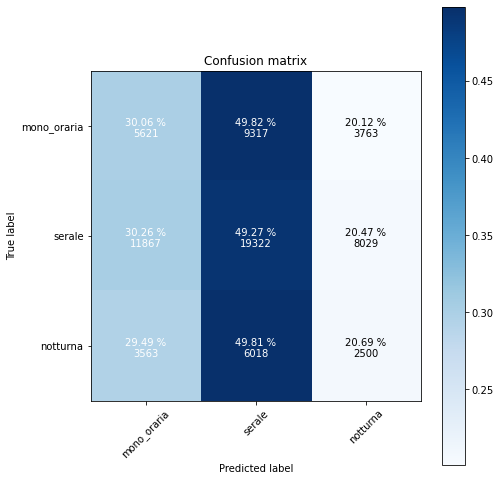

In [ ]:
cm = confusion_matrix(
    labels_df["cluster"], year_projection_df["cluster"])

# Log the confusion matrix as an image summary
figure = training_camp_21_22.view.classification.plot_cm_with_labels(
    cm, class_names=class_names);

# Random Forest Classifier

Random Forest model

In [ ]:
###### training data process; 
# features_df is a df without label; label_df inclued the cluster. these df you need to get from csv
# After computaion, we add the label
######

# year_projection = 12 * features_df.groupby(by=["user"]).mean()
# year_projection.columns = ['f1', 'f2', 'f3']
# for offer in commercial_offers:
#         year_projection[offer.name] = year_projection.apply(
#             offer.compute_yearly_cost, axis=1)
# year_projection['label']=labels_df['cluster']
# train_data = year_projection.drop(['f1','f2','f3'],axis=1)
# train_data = project_over_year(features_df, commercial_offers)

In [ ]:

#'user','citycode','cityvalue','citytypecode','citytypevalue','from_date','to_date'
# train_data['citycode'] = features_df['citycode']
# train_data['citytypecode'] = features_df['citytypecode']

In [ ]:
features_df['label'] = labels_df['cluster']

In [ ]:
features_df.user = features_df.user.astype(int)
features_df.set_index(["user"], inplace=True)

In [ ]:
features_df.head(10)

,age,location,f1,f2,f3,label
user,,,,,,
6,95,30020,44.0,73.0,0.0,1
13,69,98051,55.0,62.0,26.0,0
14,38,80121,44.0,17.0,46.0,1
17,24,20121,3.0,10.0,22.0,2
34,19,80121,0.0,0.0,35.0,2
35,52,00118,2.0,22.0,20.0,1
47,36,17100,26.0,14.0,43.0,1
52,39,20098,18.0,55.0,50.0,1
63,27,23900,6.0,35.0,43.0,1


In [ ]:
# data seletcion and process
######
# here we only need the f level data and label
######

###### data selection from csv
# task: get the var training_features_df, train_labels_df,test_features_df,test_labels_df
#training_features_df = train_data.drop(['label'],axis=1)
#train_labels_df = labels_df

test_json_input_path = '/content/training_camp_21_22/data/task_1/test.csv'

def convert_json_2_pd1(json_input_path):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    df_train=pd.read_csv(json_input_path)

    features_df = pd.DataFrame(columns=['user','age','location','fasciaF1ConsumoFatturato','fasciaF2ConsumoFatturato','fasciaF3ConsumoFatturato'])

    for i in range(len(df_train)):
      event = df_train["events"][i]
      lst = [] 
      row_data = json.loads(event)
      lst.append(df_train["user"][i])

      # bamData.items.bamItem.addresses: List of Address
      # lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['city']['code']) 
      # #lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['city']['value'])
      # lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['type']['code'])
      #lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['type']['value'])
      # bamData.items.customData: energy consumption information
      #lst.append (row_data[0]["customData"]['billing_range']['from_date'])
      #lst.append (row_data[0]["customData"]['billing_range']['to_date'])

      # bamData.items.customData.energy: Energy Consumption related for the period in scope
      lst.append(row_data[0]["bamData"]["items"]["bamItem"]["personInfo"]["birthDate"])
      lst.append(row_data[0]["bamData"]["items"]["bamItem"]["addresses"][1]['zipCode']['code'])
      lst.append( row_data[0]["customData"]["energy"]["fasciaF1ConsumoFatturato"])
      lst.append(row_data[0]["customData"]["energy"]["fasciaF2ConsumoFatturato"])
      lst.append(row_data[0]["customData"]["energy"]["fasciaF3ConsumoFatturato"])
      features_df.loc[i]=lst

    return features_df

test_features_df = convert_json_2_pd1(test_json_input_path)
#test_features_df = test_features_df.drop(['from_date','to_date'],axis=1)
test_features_df.columns=['user','age','location','f1','f2','f3']


In [ ]:
test_features_df['age'] =pd.to_datetime(test_features_df['age'])
now_year =dt.datetime.today().year 
test_features_df['age']=now_year-test_features_df.age.dt.year
test_features_df

,user,age,location,f1,f2,f3
0,90019,74,59015,30.0,31.0,14.0
1,90025,32,30022,49.0,11.0,39.0
2,90030,47,80020,18.0,33.0,36.0
3,90039,85,84048,50.0,35.0,26.0
4,90042,42,34079,0.0,16.0,57.0
...,...,...,...,...,...,...
9995,99981,55,10121,38.0,47.0,5.0
9996,99982,23,59013,3.0,0.0,27.0
9997,99989,59,71042,78.0,77.0,63.0
9998,99991,86,20017,47.0,33.0,1.0


In [ ]:
test_features_df.user = test_features_df.user.astype(int)

In [ ]:
test_features_df.set_index(["user"], inplace=True)
test_features_df

,age,location,f1,f2,f3
user,,,,,
90019,74,59015,30.0,31.0,14.0
90025,32,30022,49.0,11.0,39.0
90030,47,80020,18.0,33.0,36.0
90039,85,84048,50.0,35.0,26.0
90042,42,34079,0.0,16.0,57.0
...,...,...,...,...,...
99981,55,10121,38.0,47.0,5.0
99982,23,59013,3.0,0.0,27.0
99989,59,71042,78.0,77.0,63.0


In [ ]:
###### test data process;
# year_projection = 12 * test_features_df.groupby(by=["user"]).mean()
# for offer in commercial_offers:
#         year_projection[offer.name] = year_projection.apply(
#             offer.compute_yearly_cost, axis=1)
# test_data = year_projection.drop(['f1','f2','f3'],axis=1)
#test_data = project_over_year(test_features_df, commercial_offers)

In [ ]:

# test_data['citycode'] = test_features_df['citycode'].values
# test_data['citytypecode'] = test_features_df['citytypecode'].values

In [ ]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(features_df, label="label")


# Train a Random Forest model.
model = tfdf.keras.RandomForestModel( )

model.fit(train_ds)
# Summary of the model structure.
model.summary()


Use /tmp/tmpy2dzfqo2 as temporary training directory
Reading training dataset...


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


Training dataset read in 0:00:00.401872. Found 70000 examples.
Training model...
Model trained in 1:29:22.267092
Compiling model...
Model compiled.


Model: "random_forest_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (5):
	age
	f1
	f2
	f3
	location

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL" 13.078719 ################
    2. "location"  8.452405 ##########
    3.       "f3"  2.751533 ###
    4.       "f2"  2.631286 ##
    5.       "f1"  1.295448 #
    6.      "age"  0.305660 

Variable Importance: NUM_AS_ROOT:
    1. "age" 246.000000 ################
    2.  "f1" 54.000000 

Variable Importance: NUM_NODES:
    1. "location" 660417.000000 ################
    2.       "f2" 127576.000000 
    3.       "f3" 126809.000000 
    4.       "f1" 122962.000000 
    5.      "age" 113893.000000 

Variable Importance: SUM_SCORE:


In [ ]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [ ]:
# Get the prediction
test_set = tfdf.keras.pd_dataframe_to_tf_dataset(test_features_df)

prediction = model.predict(test_set)
prediction_result=[]
for item in prediction:
  item=list(item)
  prediction_result.append(item.index(max(item)))

## Unsupervised Learning

In [ ]:
from sklearn.cluster import KMeans
y_pred_us = KMeans(n_clusters=3, random_state=9).fit_predict(test_data)

# Submit solution to Kaggle competition

In [ ]:
test_submission = pd.DataFrame({
    "user": test_features_df.index,
    "cluster": prediction_result})
print(test_submission.head(500))
print(test_submission.shape)

Create a termporary folder for submissions

In [ ]:
!mkdir -p submissions

In [ ]:
rf_labels_path = "submissions/rf21.csv"
test_submission.to_csv(rf_labels_path, index=False)

In [ ]:
!kaggle competitions submit -c pitc-2122-clustering -f "submissions/rf.csv" -m "rf classification"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 562, in competition_submit_cli
    competition, quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 513, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submissions/rf.csv'
